# Stive differensialligninger
$\newcommand{mb}[1]{\mathbf{#1}}$

Dette notatet er egentlig en fortsettelse av notatet om ordinære differensialligninger. 
Vi kommer til å bruke kodene utviklet i det notatet i dette også. For å bedre flyten i dokumentet har jeg derfor valgt å plassere denne koden øverst, før problemstillingen beskrives. Men kjør de neste tre cellene, du vil trenge dem. 

In [3]:
# Importer nødvendige moduler, og sett parametre for plotting. 
# Dette må alltid kjøres først!
%matplotlib inline
from numpy import *               # Matematiske funksjoner og lin.alg.
from numpy.linalg import norm, solve
from matplotlib.pyplot import *   # Grafikk
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)

In [4]:
# ODL-løsere med konstant steglengde

def euler(f, x, y, h):
    # Et steg med Eulers metode
    y_neste = y + h*f(x, y)
    x_neste = x + h
    return x_neste, y_neste

def heun(f, x, y, h):
    # gjør et skritt med Heuns metode. 
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_neste = y + 0.5*h*(k1+k2)
    x_neste = x + h
    return x_neste, y_neste

def odl_loser(f, a, b, y0, h, metode=euler):
    # Løser for ordinære differensialligninger
    #    y' = f(x,y), y(a)=y0
    # Inn: f, a, b, og startverdien y0
    #      steglengde h
    #      metode: funksjon som gjør et steg med en gitt metode
    # Ut: Array med x- og y- verdier. 
    
    # Initialisering 
    
    y_num = array([y0])   # Array for løsningen y 
    x_num = array([a])    # Array for x-verdiene 

    xn = a                # Løpende verdier av x og y
    yn = y0 
    while xn < b - 1.e-10:               # Buffer for avrundingsfeil        
        xn, yn = metode(f, xn, yn, h)    # Et steg framover
        
        # Utvider arrayene for y_sol og x_sol med oppdatert løsning 
        y_num = concatenate((y_num, array([yn])))
        x_num = append(x_num,xn)
        
    return x_num, y_num

In [5]:
# Adaptive ODL løsere (med feilestimat og steglengdekontroll)

# Noen Runge-Kutta par 
# Syntaks: 
# x_neste, y_neste, feil_estimat, p = RKpar(f, x, y, h)
# Inn: f, verdier for x og y, og steglengden h
    # Ut : løsningen x og y i neste steg, basert på Heuns metode 
    #      et lokalt feilestimat. 
    #      p: orden av den laveste ordens metode

def heun_euler(f, x, y, h):
    # Et steg med Heuns og Eulers metodod
    # Orden 2(1)
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_neste = y + 0.5*h*(k1+k2)      # Heuns metode (lokal ekstrapolasjon)
    x_neste = x + h
    feil_estimat = 0.5*h*norm(k2-k1)
    p = 1
    return x_neste, y_neste, feil_estimat, p

# Vår basis adaptive metode
def odl_adaptiv(f, a, b, y0, h0, tol = 1.e-6, metode=heun_euler):
    # Løser for ordinære differensialligninger
    #    y' = f(x,y), y(a)=y0
    # med en adaptive metode (varierende steglengde)
    # Inn: f, a, b, og startverdien y0
    #      startsteglengde h, og en toleranse tol. 
    #      metode: funksjon som gjør et steg med en gitt metode
    # Ut: Array med x- og y- verdier. 
    
    y_num = array([y0])   # Array for løsningen y 
    x_num = array([a])    # Array for x-verdiene 

    xn = a                # Løpende verdier av x, y og steglengde
    yn = y0 
    h = h0
    Max_metodekall = 1000000        # Maksimalt antall kall av metode 
    n_metodekall = 0
    
    # Hovedløkke:
    while xn < b - 1.e-10:               # Buffer for avrundingsfeil 
        # Juster steglengden for siste steg.
        if xn + h > b:                   
            h = b - xn 
        
        # Gjør et steg med valgt metode
        x_forsok, y_forsok, feil_estimat, p = metode(f, xn, yn, h)
        n_metodekall = n_metodekall + 1
        
        if feil_estimat <= tol:   
            # Løsningen godkjennes, xn og yn oppdateres 
            xn = x_forsok      
            yn = y_forsok
            # Utvider arrayene for y_sol og x_sol med oppdatert løsning 
            y_num = concatenate((y_num, array([yn])))
            x_num = append(x_num, xn)
        
        # else: steget forkastes, ingen oppdatering av xn og yn. 
        
        # Juster  steglengden (0.8 er pessimistfaktoren)
        h = 0.8*(tol/feil_estimat)**(1/(p+1))*h
        
        # Stopp hvis maks antall kall av metoden er gjort
        if n_metodekall > Max_metodekall:
            print('Maks antall metodekall nådd')
            return x_num, y_num
    print('Antall godkjente steg =  ', len(x_num)-1)
    print('Antall forkastede steg = ', n_metodekall - len(x_num)+1)
    return x_num, y_num

# Problemstilling
La oss starte med et lite eksperiment. 

Gitt systemet av to differensialligninger

\begin{align}
  y_1' &= -2y_1 + y_2 + 2\sin(x), & y_1(0) &= 2, \\
  y_2' &= (a-1) y_1 - a y_2 + a\,\big(\cos(x)-\sin(x) \big), & y_2(0) &= 3,
\end{align}

med eksakt løsning

$$ y_1(x) = 2 e^{-x} + \sin(x), \qquad y_2(x) = 2e^{-x} + \cos(x). $$

og løs dette med en adaptiv ligningsløser, f.eks. Heun-Euler, med ulike toleranser. Det er rimelig å anta at totalt antall steg $N$ øker når toleransen blir mindre, men hvordan? 

Forutsetningen for skrittlengdekontrollen er antagelsen

$$ lf_{n+1} \approx Dh_n^{p+1} \approx \text{Tol}, $$

der $p$ er ordenen til metoden med lavest orden, og $D$ er en "konstant", den er uavhengig av steglengden $h$, den vil variere med løsningen $x, y(x)$, men ikke mye fra et steg til det neste. 

Løser vi samme problem med samme metode, men med to ulike toleranser $\text{Tol}_1$ og $\text{Tol}_2$ vil vi forvente at de korresponderende steglengdene $h_1$ og $h_2$ nær et og det samme vilkårlige løsningspunkt oppfører seg omtrent som følger:

$$
   \text{Tol}_1 \approx D (h_{1})^{p+1}, \qquad 
   \text{Tol}_2 \approx D (h_2)^{p+1} 
$$
slik at
$$
    \frac{h_1}{h_2} \approx \left( \frac{\text{Tol}_1}{\text{Tol}_2} \right)^{\frac{1}{p+1}} \approx \frac{N_2}{N_1}. 
$$

der $N_1$ og $N_2$ er totalt antall steg for de to toleransene. 

For Heun-Euler er $p=1$, så ved å redusere toleransen med en faktor 100, forventer vi at antall steg øker med en faktor 10. Skjer det? 

La $\text{Tol}=10^{-2}, \, 10^{-4}, \, 10^{-6}$. 

Prøv med $a=2$ og $a=999$. 



Tol = 1.0e-02
Antall godkjente steg =   93
Antall forkastede steg =  2

Tol = 1.0e-04
Antall godkjente steg =   869
Antall forkastede steg =  1

Tol = 1.0e-06
Antall godkjente steg =   8631
Antall forkastede steg =  1


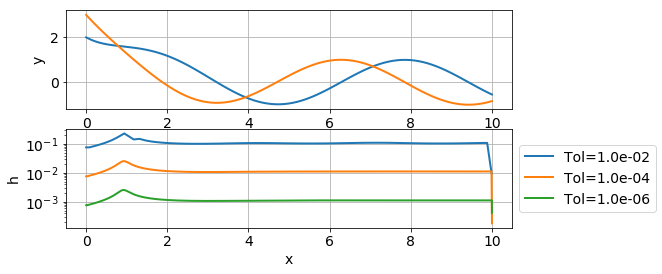

In [6]:
# Definer funksjonen.
def f(x, y):
    a = 2
    dy = array([-2*y[0]+y[1]+2*sin(x),
                (a-1)*y[0]-a*y[1]+a*(cos(x)-sin(x))])
    return dy

# Startverdier og integrasjonsintervall 
y0 = array([2, 3])
a, b = 0, 10
h0 = 0.1

tol = 1.e-2
# Løser ligningen med toleranser 
for n in range(3):
    print('\nTol = {:.1e}'.format(tol)) 
    x_num, y_num = odl_adaptiv(f, a, b, y0, h0, tol, metode=heun_euler)
    
    if n==0:
        # Plotter løsningen
        subplot(2,1,1)
        plot(x_num, y_num)
        ylabel('y')
        subplot(2,1,2)

    # Plotter steglengdekontrollen
    semilogy(x_num[0:-1], diff(x_num), label='Tol={:.1e}'.format(tol));
    
    tol = 1.e-2*tol         # Reduserer toleransen med en faktor 100.
xlabel('x')
ylabel('h')
legend(loc='center left', bbox_to_anchor=(1, 0.5));

For $a=2$ ser vi forventet oppførsel. For $a=999$ derimot, brukes det like mange steg for $\text{Tol}=10^{-2}$ som for $\text{Tol}=10^{-4}$, og  det brukes langt flere steg enn tilfellet var for $a=2$, til tross for at løsningen er den samme. 

##### Numeriske eksperiment
1. Gjenta eksperimentet med Van der Pols ligning

  \begin{align}
    y_1' &= y_2, & y_1(0) &= 2,  \\
    y_2' &= \mu(1-y_1^2)y_2 - y_1, & y_2(0) &= 0
   \end{align}
   
   Bruk $\mu=2$, $\mu=5$ og $\mu=50$. 


Denne oppførselen, at steglengden ikke endres vesentlig med toleransen, og at det brukes uforholdsmessig mange steg er en typisk oppførsel for en _stiv differensialligning_. I resten av dette notatet skal vi forklare dette fenomenet, og hva som må gjøres for å omgå det. 

## Lineær stabilitetsanalyse

### Motivasjon
Gitt et system av $d$ ligninger på formen 

$$ \mb{y}' = A \mb{y} + \mb{g}(x) \tag{*} $$

Slike systemer er diskutert i Matematikk 3. En teknikk for å løse disse går omtrent som følger: 

* Løs først den homogene ligningen $\mb{y}' = A \mb{y}$, det vil si finn egenverdiene og egenvektorene til $A$: 

   $$ A\mb{v}_i = \lambda_i \mb{v_i}, \qquad i=1,2,\dotsc,d. \tag{**} $$
  
  
* Anta at $A$ har et fullt sett med lineært uavhengige egenvektorer
  $\mb{v}_i$. La $V=[\mb{v}_1,\dots,\mb{v}_d]$, og
  $\Lambda = \text{diag}\{\lambda_1,\dotsc,\lambda_d\}.$  I så fall er $V$   inverterbar og

   $$ AV = V\Lambda \qquad \Leftrightarrow \qquad V^{-1}AV = \Lambda. $$

  Vår ODL (*) kan da skrives om til

  $$ V^{-1} \mb y' = V^{-1}A V V^{-1} \mb{y}+ V^{-1}\mb{g}(x). $$ 

  La $\mb{z} = V^{-1}y$ og $\mb{q}(x)=V^{-1}(x)$ slik at ligningen kan dekobles i et sett uavhengige skalare ligninger

  $$ 
  \mb{z}' = \Lambda \mb{z} + \mb{q}(x) \qquad \Leftrightarrow \qquad 
  z_i' = \lambda_i z_i + q_i(x), \quad i=1,\dotsc, d.
  $$
  
  Løsningen av slike ligninger ble diskutert i [Matematikk 1](https://wiki.math.ntnu.no/tma4100/tema/differentialequations). 
  Har vi funnet disse er den eksakte løsningen av (*) gitt ved
  
  $$ \mb{y}(x) = V \mb{z}(x). $$
  
  Integrasjonskonstantene finnes fra startbetingelsene. 
  
Det viser seg at det er egenverdiene $\lambda_i$ som nøkkelfaktoren for å forstå oppførselen til integratorene, som vist ovenfor. I en lineær stabilitetsanalyse vil vi derfor studere den meget forenklede testligningen 

$$ y' = \lambda y $$

som sees på som en representant for det dekoblede systemet over. 
  
I praksis er ofte egenverdiene, og dermed også egenvektorene komplekse. I så fall opptrer de i kompleks konjugerte par som kan slås sammen til trigonometriske funksjoner. I dette notatet kommer vi for enkelthets skyld til å anta at egenverdiene er reelle, men all videre diskusjon kan (og bør egentlig) også omfatte komplekse egenverdier. Analysen har også  relevans for ikkelineære ODL $\mb{y}' = \mb{f}(x,\mb{y})$. I så fall kan $\lambda$ betraktes som en egenverdi av Jakobimatrisen $\mb{f}_y$. 
  
##### Eksempel 
Gå tilbake til eksempelet fra innledningen. Dette kan skrives som

$$ \mb{y}' = A \mb{y} + \mb{g}(x) $$

med 

$$
A = \begin{bmatrix} -2 & 1 \\ a-1 & -a \end{bmatrix}, \qquad
\mb{g}(x) = \begin{bmatrix}\sin(x) \\ a(\cos(x)-\sin(x)) \end{bmatrix}\
$$

Matrisen $A$ har egenverdiene $\lambda_1 = -1$ og $\lambda_2 = -(a+1)$.
Den generelle løsningen av ligningen blir

$$ \mb{y}(x) = c_1 \begin{bmatrix} 1 \\ 1 \end{bmatrix} e^{-x} 
             + c_2 \begin{bmatrix} -1 \\ a-1 \end{bmatrix} e^{-(a+1)x}
             + \begin{bmatrix} \sin(x) \\ \cos(x) \end{bmatrix} 
$$

I eksempelet i innledningen er startverdiene valgt slik at $c_1=2$ og $c_2=0$. Imidlertid, for $a$ stor vil $e^{-(a+1)x}$ gå mot 0 nesten umiddelbart selv om startverdiene var valgt slik $c_2\not=0$. Det er likefullt dette leddet som skaper problemer for den numeriske løsningen.

### Stabilitetsfunksjon og stabilitetsintervall. 

Gitt den lineære testligningen 

$$ y' = \lambda y, \qquad y(0)=y_0, \qquad \lambda \in \mathbb{R}, \qquad \lambda < 0.$$

Den eksakte løsningen er gitt ved

$$ y(x) = e^{\lambda x} \, y_0. $$

Siden $\lambda < 0$ vil $y(x) \rightarrow 0$ når $x\rightarrow \infty$. 
Vi ønsker en tilsvarende oppførsel av vår numeriske metode, det vil si at 
$ |y_{n}| \rightarrow 0$ når $n\rightarrow \infty$. Men når oppnås det? 

Dersom en Runge-Kutta metode anvendes på 
vil et steg med metoden alltid kunne skrives på formen

$$ y_{n+1} = R(z)y_n, \qquad z=\lambda h $$

Funksjonen $R(z)$ kalles metodens _stabilitetsfunksjon_. 

Tar vi absoluttverdien på begge sider ser vi at det er tre muligheter: 

\begin{align*}
|R(z)| & < 1 \quad \Rightarrow  & |y_{n+1}| & < |y_n| \quad \Rightarrow && y_n \rightarrow 0 &&\text{(stabil)} \\
|R(z)| &= 1  \quad \Rightarrow   & |y_{n+1}| & = |y_n| \\
|R(z)| &> 1  \quad \Rightarrow   & |y_{n+1}| &> |y_n| \quad \Rightarrow  && |y_n| \rightarrow \infty && (\text{ustabil})
\end{align*}

Vi må altså unngå at $|R(z)|>1$. En metodes _stabilitetsintervall_ er definert som 

$$ \mathcal{S} = \{ z \in \mathbb{R} \; :\; |R(z)| \leq 1 \}.$$

For å oppnå en stabil løsning må altså steglengden $h$ velges slik at 
$z=\lambda h$ ligger i metodens stabilitetsintervall. 

##### Eksempel: Eulers metode 
Eulers metode anvendt på testligningen blir 

$$ y_{n+1} = y_n + h\lambda y_n = (1+h\lambda)y_n $$

så stabiltetsfunksjonen og stabilitetsintervaller er 

$$ R(z) = 1+z, \qquad \mathcal{S}=[-2,0]. $$

La oss nå løse ligningen fra innledningen:

$$
\mb{y}' = \begin{bmatrix} -2 & 1 \\ a-1 & -a \end{bmatrix} + 
\begin{bmatrix}\sin(x) \\ a(\cos(x)-\sin(x)) \end{bmatrix},
\qquad \mb{y}(0) = \begin{bmatrix} 2 \\ 3 \end{bmatrix}, \qquad a>0.
$$

ved hjelp av Eulers metode. Vi vet at egenverdiene til matrisen er 
$\lambda_1 = -1$ og $\lambda_2 = -(1+a)$. 
For at metoden skal være stabil for begge egenverdiene må 

$$ h \leq \frac{2}{1+a}. $$

Velg f.eks. $a=9$ og $a=999$. Velg steglengder litt over og litt under stabilitetsgrensen, og du vil se at stabilitetsbetingelsen er skarp (velg lengre integrasjonsintervall om nødvendig). 

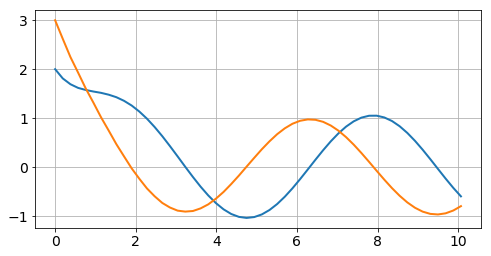

In [7]:
def f(x, y):
    # y' = f(x,y) = A*y+g(x)
    a = 9
    dy = array([-2*y[0]+y[1]+2*sin(x),
                (a-1)*y[0]-a*y[1]+a*(cos(x)-sin(x))])
    return dy

# Startverdier og integrasjonsintervall 
y0 = array([2, 3])
a, b = 0, 10
h = 0.19

x_num, y_num = odl_loser(f, a, b, y0, h, metode=euler)
plot(x_num, y_num);

Det er bidraget fra leddet som korresponderer til egenverdien $\lambda_2=-(a+1)$ som gjør løsningen ustabil når $h>1/(a+1)$. Oscillasjonene skyldes at $R(z)<-1$ for $h<2/(1+a)$. 

##### Oppgave og numerisk eksperiment 
1. Vis at stabilitetsfunksjonen og stabilitetsintervallet for Heuns 
    metode er henholdsvis

    $$ R(z) = 1+z + \frac{1}{2}z^2 $$

    og 

    $$ \mathcal{S}=[-2, 0]. $$

2. Gjenta eksperimentet over med Heuns metode. 

**NB!** Adaptive metoder vil automatisk holde steglengden innenfor (eller svært nær) stabilitetsintervallet. Dette forklarer oppførselen til eksperimentet i innledningen av dette notatet. 

# $A(0)$-stabile metoder. 

Ideelt sett vil vi ønske metoder med et stabilitetsintervall som inkluderer alle negative tall, dvs. $|R(z)| < 1 $ for alle $z<0$. 
Slike metoder kalles $A(0)$-stabile. 

Det kan vises at for alle eksplisitte metoder vil $R(z)$ være et polynom, dermed vil $R(z) \rightarrow \pm \infty$. Eksplisitte metoder kan altså ikke være $A(0)$-stabile, så vi må lete blant implisitte metoder. Den enkleste av disse er implisitt (eller baklengs) Eulers metode, gitt ved

$$  y_{n+1} = y_n + hf(x_{n+1}, y_{n+1}). $$

Anvendt på den lineære testligningen $y'=\lambda y$:

$$ 
y_{n+1} = y_n + h\lambda y_{n+1} \qquad \Rightarrow \qquad 
y_{n+1} = \frac{1}{1-h\lambda} 
\qquad \Rightarrow \qquad R(z) = \frac{1}{1-z}.
$$ 

Og siden $|R(z)|\leq 1$ for alle $z\leq 0$ er implisitt Euler $A(0)$-stabil. 

## Implementasjon av baklengs Euler
Av renspikket dovenskap begrenser vi oss til å se på implementasjonen av Eulers metode på lineære ligningsysstemer

$$ \mb{y}' = A\mb{y} + \mb{g}(x), $$

der $A$ er en konstant matrise. Et steg med baklengs Euler anvendt på dette er gitt ved

$$ \mb{y}_{n+1} = \mb{y}_n + hA\mb{y}_{n+1} + h\mb{g}(x_{n+1}) $$

det betyr at vi må løse et lineært ligningssystem på formen

$$ (I - hA)\mb{y}_{n+1} = \mb{y}_n + h \mb{g}(x_{n+1}) $$

for hvert steg. 

I implementasjonen under er differensialligningen implementert som en funksjon `rhs` (right hand side) som returnerer matrisen $A$ og vektoren $\mb{g}(x)$. 

Funksjonen `implisitt_euler` gjør et steg med implisitt Euler. Denne har samme grensesnitt (argumenter inn og ut) som de eksplisitte metodene implementert tidligere, så vår generelle odl-løser kan brukes direkte. 

In [10]:
def implisitt_euler(rhs, x, y, h):
    # Et steg med implisitt Eulers metode for differensialligninger på 
    #              y' = Ay + g(x)
    # Funksjonen f har grensesnittet
    #     A, gx = rhs(x)
    A, gx = rhs(x+h)
    d = len(gx)                  # dimensjonen til systemet
    M = eye(d)-h*A               # M = I-hA
    b = y + h*gx                 # b = y + hf(x)
    y_neste = solve(M, b)        # Løs M y_neste = b
    x_neste = x+h
    return x_neste, y_neste

##### Testing
Løs testligningen 

$$
A = \begin{bmatrix} -2 & 1 \\ a-1 & -a \end{bmatrix}, \qquad
\mb{f}(x) = \begin{bmatrix}\sin(x) \\ a(\cos(x)-\sin(x)) \end{bmatrix}\
$$

med implisitt Euler. Velg $a=2$ og  $a=999$, og prøv ulike steglengder som f.eks. $h=0.1$ og $h=0.01$. 

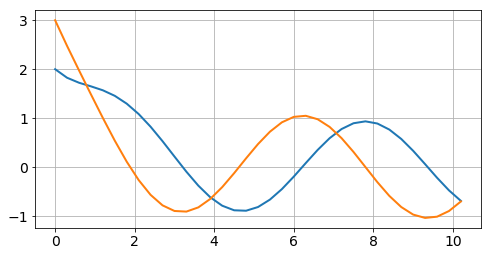

In [11]:
def rhs(x):
    # Høyresiden (rhs) av differensialligningen y' = Ay + g(x)
    # Returnerer matrisen A og g(x).
    a = 9
    A = array([[-2, 1],[a-1, -a]])
    gx = array([2*sin(x), a*(cos(x)-sin(x))])
    return A, gx

# Startverdier og integrasjonsintervall 
y0 = array([2, 3])
a, b = 0, 10
h = 0.3

x_num, y_num = odl_loser(rhs, a, b, y0, h, metode=implisitt_euler)
plot(x_num, y_num);

##### Oppgave og numerisk eksperiment
Trapesmetoden er en implisitt metode som for en generell ODL $y'=f(x,y)$ er gitt ved

$$ y_{n+1} = y_{n} + \frac{h}{2}\bigg( f(x_n,y_n) + f(x_{n+1},y_{n+1})\bigg). $$

1. Finn stabilitetsfunksjonen til trapesmetoden og vis at den er $A(0)$-stabil. 
2. Implementer trapesmetoden, og gjenta eksperimentet over. 

## Adaptive metoder. 

Baklengs Euler er en metode av orden 1, trapesmetoden av orden 2. Vi kan dermed bruke disse to for feilestimering: Ta et steg med hver av metodene, bruk differensen mellom dem som feilestimat, og bruk løsningen fra trapesmetoden (den beste) som $\mb{y}_{n+1}$. 
Dette er implementert for lineære ligninger i  `trapes_ieuler`. Denne har samme grensesnitt som `heun_euler` implementert tidligere, så den adaptive løseren `odl_adaptiv` kan brukes som før.

In [12]:
def trapes_ieuler(rhs, x, y, h):
    # Et steg med trapes og implisitt Euler for ODL på formen
    #              y' = Ay + f(x)
    # Funksjonen f har grensesnittet
    #     A, fx = rhs(x)
    # Orden 2(1)
    A, gx1 = rhs(x+h)
    A, gx0 = rhs(x)
    d = len(gx1)
    
    # Et steg med implisitt Euler
    M = eye(d)-h*A
    b = y + h*gx1
    y_ie = solve(M, b)
    
    # Et steg med trapes
    M = eye(d)-0.5*h*A
    b = y + 0.5*h*dot(A,y) + 0.5*h*(gx0+gx1)
    y_neste = solve(M, b)                       # Løsningen
    
    feil_estimat = norm(y_neste-y_ie)
    x_neste = x + h
    p = 1
    return x_neste, y_neste, feil_estimat, p

Gjenta eksperimentet fra innledningen med denne metoden: 


Tol = 1.0e-02
Antall godkjente steg =   76
Antall forkastede steg =  7

Tol = 1.0e-04
Antall godkjente steg =   751
Antall forkastede steg =  8

Tol = 1.0e-06
Antall godkjente steg =   7415
Antall forkastede steg =  2


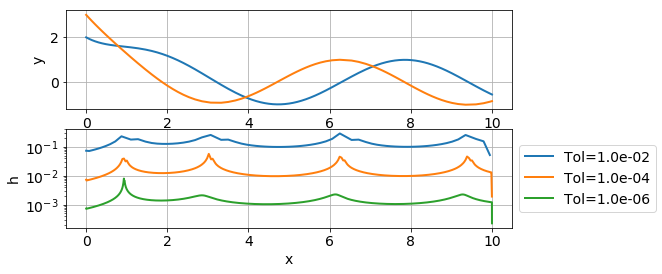

In [13]:
def rhs(x):
    # Høyresiden (rhs) av differensialligningen y' = Ay + g(x)
    # Returnerer matrisen A og f(x).
    a = 999
    A = array([[-2, 1],[a-1, -a]])
    gx = array([2*sin(x), a*(cos(x)-sin(x))])
    return A, gx

# Startverdier og integrasjonsintervall 
y0 = array([2, 3])
a, b = 0, 10
h0 = 0.1

tol = 1.e-2

# Løser ligningen med ulike toleranser
for n in range(3):
    print('\nTol = {:.1e}'.format(tol)) 
    x_num, y_num = odl_adaptiv(rhs, a, b, y0, h0, tol, metode=trapes_ieuler)
    
    if n==0:
        # Plotter løsningen
        subplot(2,1,1)
        plot(x_num, y_num)
        ylabel('y')
        subplot(2,1,2)

    # Plotter steglengdekontrollen
    semilogy(x_num[0:-1], diff(x_num), label='Tol={:.1e}'.format(tol));
    
    tol = 1.e-2*tol         # Reduserer toleransen med en faktor 100.

# Dekorasjon
xlabel('x')
ylabel('h')
legend(loc='center left', bbox_to_anchor=(1, 0.5));

Og vi observerer at her er det ingen steglengdebegrensing pga. stabilitet. 

**Problem solved. **

_Kommentar_: 

Implisitte metoder kan også anvendes for ikke-lineære ligninger. I så fall må et eller flere ikke-lineære ligningssystem løses for hvert steg. Det gjøres vanligvis ved en forenklet versjon av Newtons metode. 